## Deep Learning Term Project for ECG (DIL700)

# Iteration 4

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras import Sequential
from keras.layers import Convolution1D, MaxPool1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import GPyOpt

import warnings
warnings.filterwarnings('ignore')

import datetime

# Custom functions
from general_functions import *

# Loading dataset

    Number of Samples: 14552
    Number of Categories: 2
    Sampling Frequency: 125Hz
    Data Source: Physionet's PTB Diagnostic Database

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [2]:
normal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)
# Combine to a full dataset
full_df = pd.concat([normal_df, abnormal_df], axis=0, ignore_index=True)

In [3]:
print('Number of samples per class: \n')
print('Normal:                 ', len(full_df[full_df[187]==0]))
print('Abnormal:               ', len(full_df[full_df[187]==1]))

Number of samples per class: 

Normal:                  4046
Abnormal:                10506


In [4]:
normal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Normal only contains class 0 --> healthy
normal_df[187].unique()

array([0.])

In [6]:
abnormal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Abnormal only contains class 1 --> not healthy
abnormal_df[187].unique()

array([1.])

In [8]:
full_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14548,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14549,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14550,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Full contains both classes
full_df[187].unique()

array([0., 1.])

In [10]:
labels = ['Normal', 'Abnormal']

# Preparation

In [11]:
from sklearn.model_selection import train_test_split

# split the data into features and target
X = full_df.drop(187, axis=1)
y = full_df[187]

# Split data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [12]:
# validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42)

In [13]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.052197,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [14]:
train_df = X_train.copy()
train_df[187] = y_train
valid_df = X_valid.copy()
valid_df[187] = y_valid
test_df = X_test.copy()	
test_df[187] = y_test

train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


In [15]:
print('Number of samples in training data:')
print('Normal:                              ', len(train_df[train_df[187]==0]))
print('Abnormal:                            ', len(train_df[train_df[187]==1]))

Number of samples in training data:
Normal:                               2589
Abnormal:                             6723


In [16]:
print('Number of samples in validation data:')
print('Normal:                              ', len(valid_df[valid_df[187]==0]))
print('Abnormal:                            ', len(valid_df[valid_df[187]==1]))

Number of samples in validation data:
Normal:                               648
Abnormal:                             1681


In [17]:
print('Number of samples in test data:')
print('Normal:                              ', len(test_df[test_df[187]==0]))
print('Abnormal:                            ', len(test_df[test_df[187]==1]))

Number of samples in test data:
Normal:                               809
Abnormal:                             2102


Same ratio of the two classes in both the datasets

# Hyperparameter optimization ANN

CM of initial ANN

756 &emsp;&emsp;53

23  &emsp;&emsp;2079

Info about the algo: https://www.blopig.com/blog/wp-content/uploads/2019/10/GPyOpt-Tutorial1.html

In [18]:
timestamp = datetime.datetime.now().strftime("%d%m%Y_%H%M%S")
report_file = 'gpyopt_ann_2' + '_' + timestamp + '.txt'
f = open(report_file, "x")
f.close()

cell_outputs = []

# define the search space for the Bayesian optimization
space = [{'name': 'num_layers', 'type': 'discrete', 'domain': (5, 6, 7, 8, 9, 10, 11, 12)},
         {'name': 'num_neurons', 'type': 'discrete', 'domain': (8, 16, 32)},
         {'name': 'activation', 'type': 'discrete', 'domain': (0, 1, 2, 3)}]
max_iter = 500
epochs = 40

# testing only, remove later
if False:
    space = [{'name': 'num_layers', 'type': 'discrete', 'domain': (1, 2)},
            {'name': 'num_neurons', 'type': 'discrete', 'domain': (4, 5)},
            {'name': 'activation', 'type': 'discrete', 'domain': (1, 2)}]
    max_iter = 5
    epochs = 2

# define the objective function to be optimized
def objective_function(x):

    num_layers = int(x[:, 0])
    num_neurons = int(x[:, 1])
    activations = ['sigmoid', 'tanh', 'relu', 'selu']
    activation_func = activations[int(x[:, 2])]

    # create the model from the custom function
    model = ann_network(num_layers, num_neurons, activation_func, 2, X_train)

    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    # docs
    cell_outputs.append(f'Fitting model: {num_layers} layers, {num_neurons} neurons, {activation_func} \t\t')
    print(f'Fitting model: {num_layers} layers, {num_neurons} neurons, {activation_func}', end='\t\t')

    # train the model and return the validation accuracy
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=epochs, verbose=0)
    val_acc = max(history.history['val_accuracy'])

    # docs
    cell_outputs.append(f'Best validation accuracy: {val_acc*100:.2f} %')
    cell_outputs.append('\n')
    print(f'Best validation accuracy: {val_acc*100:.2f} %')
    print()

    return -val_acc  # negative because GPyOpt minimizes the objective function

# specify the initial design points for Bayesian optimization
# design = np.array([[4, 16, 'relu'], [4, 32, 'sigmoid'], [5, 32, 'tanh']])

# create a GPyOpt object and run Bayesian optimization
bo = GPyOpt.methods.BayesianOptimization(f=objective_function, 
                                         domain=space, 
                                         verbosity=True, 
                                         verbosity_model=True, 
                                         exact_feval=True,
                                         initial_design_numdata = 50) #, initial_design=design)

bo.run_optimization(max_iter=max_iter, report_file=report_file)

# print the optimal architecture and validation accuracy
opt_num_layers = int(bo.x_opt[0])
opt_num_neurons = int(bo.x_opt[1])
activations = ['sigmoid', 'tanh', 'relu', 'selu']
best_activation = activations[int(bo.x_opt[2])]
opt_val_acc = -bo.fx_opt
print(f"Optimal architecture: {opt_num_layers} layers, {opt_num_neurons} neurons per layer, {best_activation} activation function")
print(f"Optimal validation accuracy: {opt_val_acc:.5f}")

# save results to text file
with open(report_file, 'a') as file1:
    file1.write("\n---------- Cell outputs ----------\n")
    for i in range(len(cell_outputs)):
        file1.write(cell_outputs[i])
    file1.write('\n')
    file1.write(f"Optimal architecture: {opt_num_layers} layers, {opt_num_neurons} neurons per layer, {best_activation} activation function")
    file1.write('\n')
    file1.write(f"Optimal validation accuracy: {opt_val_acc:.5f}")


Fitting model: 8 layers, 16 neurons, sigmoid		Best validation accuracy: 88.71 %

Fitting model: 5 layers, 16 neurons, tanh		Best validation accuracy: 96.48 %

Fitting model: 8 layers, 16 neurons, selu		Best validation accuracy: 97.25 %

Fitting model: 9 layers, 8 neurons, relu		Best validation accuracy: 95.62 %

Fitting model: 6 layers, 8 neurons, sigmoid		Best validation accuracy: 85.74 %

Fitting model: 7 layers, 32 neurons, relu		Best validation accuracy: 96.31 %

Fitting model: 9 layers, 32 neurons, tanh		Best validation accuracy: 79.05 %

Fitting model: 7 layers, 32 neurons, tanh		Best validation accuracy: 95.84 %

Fitting model: 8 layers, 32 neurons, relu		Best validation accuracy: 97.38 %

Fitting model: 8 layers, 8 neurons, relu		Best validation accuracy: 96.22 %

Fitting model: 6 layers, 32 neurons, sigmoid		Best validation accuracy: 92.06 %

Fitting model: 11 layers, 16 neurons, relu		Best validation accuracy: 96.39 %

Fitting model: 8 layers, 8 neurons, tanh		Best validation

In [18]:
best_ann = ann_network(num_layers=opt_num_layers, num_neurons_last_hidden=opt_num_neurons, activation_function=best_activation, num_classes=2, X_train=X_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath='best_ann_2_opt.h5', monitor='val_loss', save_best_only=True)]

# train the model
history_ann_opt = best_ann.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

best_ann.load_weights('best_ann_2_opt.h5')
save_model(best_ann, 'Optimized_ANN_PTBDB', 'keras')

Epoch 1/100
291/291 [==============================] - 1s 3ms/step - loss: 0.4003 - accuracy: 0.8070 - val_loss: 0.3404 - val_accuracy: 0.8476
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3080 - accuracy: 0.8573 - val_loss: 0.2769 - val_accuracy: 0.8772
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.2687 - accuracy: 0.8782 - val_loss: 0.2531 - val_accuracy: 0.8866
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.2356 - accuracy: 0.8947 - val_loss: 0.2461 - val_accuracy: 0.8901
Epoch 5/100
291/291 [==============================] - 0s 2ms/step - loss: 0.2112 - accuracy: 0.9105 - val_loss: 0.2068 - val_accuracy: 0.9171
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.2095 - accuracy: 0.9074 - val_loss: 0.2057 - val_accuracy: 0.9150
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.1748 - accuracy: 0.9292 - val_loss: 0.1817 - val_accuracy: 0.9300

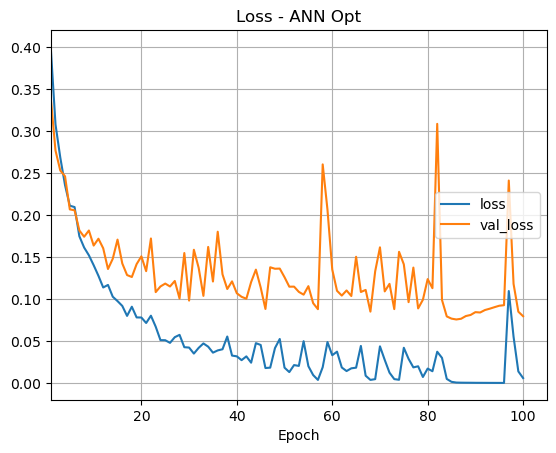

In [35]:
history_df_ann = pd.DataFrame(history_ann_opt.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN Opt")
plt.legend(cols, loc="right")
plt.show()

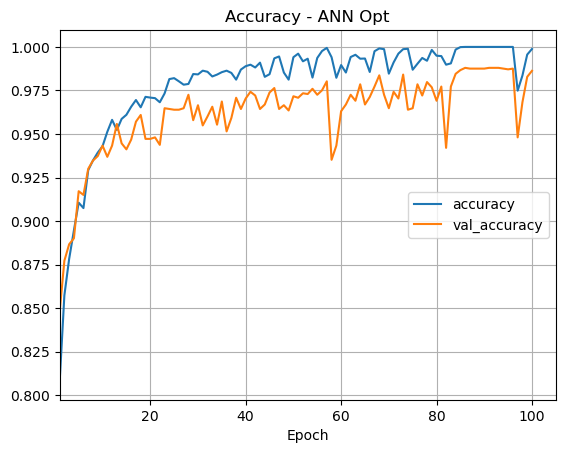

In [34]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN Opt")
plt.legend(cols, loc="right")
plt.show()

In [21]:
# Predict test set labels
y_pred_ann_proba = best_ann.predict(X_test, verbose=0)
y_pred_ann = np.where(y_pred_ann_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred_ann):.5f}')

Accuracy: 0.98042


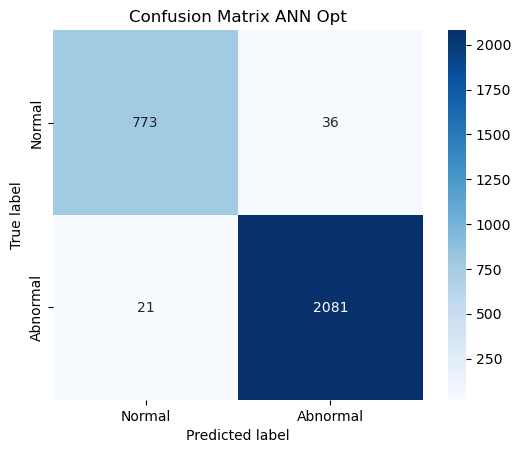

In [30]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure()
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix ANN Opt')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [23]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9736    0.9555    0.9644       809
    Abnormal     0.9830    0.9900    0.9865      2102

    accuracy                         0.9804      2911
   macro avg     0.9783    0.9728    0.9755      2911
weighted avg     0.9804    0.9804    0.9804      2911



# Hyperparameter optimization CNN

CM of initial CNN

756 &emsp;&emsp;18

14  &emsp;&emsp;2079

In [25]:
timestamp = datetime.datetime.now().strftime("%d%m%Y_%H%M%S")
report_file = 'gpyopt_cnn_2' + '_' + timestamp + '.txt'
f = open(report_file, "x")
f.close()

cell_outputs = []

# define the search space for the Bayesian optimization
space = [
    {'name': 'num_conv_blocks', 'type': 'discrete', 'domain': (1, 2, 3, 4, 5, 6)},
    {'name': 'strides', 'type': 'discrete', 'domain': (1, 2)},
    {'name': 'num_dense_layers', 'type': 'discrete', 'domain': (1, 2, 3, 4)},
    {'name': 'num_neurons_last_hidden', 'type': 'discrete', 'domain': (8, 16, 32, 64)},
]
max_iter = 500
epochs = 40

# testing only, remove later
if False:
    space = [
        {'name': 'num_conv_blocks', 'type': 'discrete', 'domain': (1, 2)},
        {'name': 'strides', 'type': 'discrete', 'domain': (1, 2)},
        {'name': 'num_dense_layers', 'type': 'discrete', 'domain': (1, 2)},
        {'name': 'num_neurons_last_hidden', 'type': 'discrete', 'domain': (4, 8)},
    ]
    max_iter = 3
    epochs = 1


# define the objective function to be optimized
def objective_function(x):

    num_conv_blocks = int(x[:, 0])
    strides = int(x[:, 1])
    num_dense_layers = int(x[:, 2])
    num_neurons_last_hidden = int(x[:, 3])

    # create the model from the custom function
    model = cnn_network(num_conv_blocks, strides, num_dense_layers, num_neurons_last_hidden, 2, X_train)

    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    # docs
    cell_outputs.append(f'Fitting model: {num_conv_blocks} conv blocks, {strides} striding for pool, {num_dense_layers} dense layers, {num_neurons_last_hidden} neurons on last dense layer \t\t')
    print(f'Fitting model: {num_conv_blocks} conv blocks, {strides} striding for pool, {num_dense_layers} dense layers, {num_neurons_last_hidden} neurons on last dense layer', end='\t\t')

    # train the model and return the validation accuracy
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=epochs, verbose=0)
    val_acc = max(history.history['val_accuracy'])

    # docs
    cell_outputs.append(f'Best validation accuracy: {val_acc*100:.2f} %')
    cell_outputs.append('\n')
    print(f'Best validation accuracy: {val_acc*100:.2f} %')
    print()

    return -val_acc  # negative because GPyOpt minimizes the objective function

# create a GPyOpt object and run Bayesian optimization
bo = GPyOpt.methods.BayesianOptimization(f=objective_function, 
                                         domain=space, 
                                         verbosity=True, 
                                         verbosity_model=True, 
                                         exact_feval=True,
                                         initial_design_numdata = 50)

bo.run_optimization(max_iter=max_iter, report_file=report_file)

# print the optimal architecture and validation accuracy
opt_num_convblocks = int(bo.x_opt[0])
opt_num_strides = int(bo.x_opt[1])
opt_num_dense_layers = int(bo.x_opt[2])
opt_num_neurons_last_hidden = int(bo.x_opt[3])
opt_val_acc = -bo.fx_opt
print(f"Optimal architecture: {opt_num_convblocks} conv blocks, {opt_num_strides} striding for pool, {opt_num_dense_layers} dense layers, {opt_num_neurons_last_hidden} neurons on last dense layer")
print(f"Optimal validation accuracy: {opt_val_acc:.5f}")

# save results to text file
with open(report_file, 'a') as file1:
    file1.write("\n---------- Cell outputs ----------\n")
    for i in range(len(cell_outputs)):
        file1.write(cell_outputs[i])
    file1.write('\n')
    file1.write(f"Optimal architecture: {opt_num_convblocks} conv blocks, {opt_num_strides} striding for pool, {opt_num_dense_layers} dense layers, {opt_num_neurons_last_hidden} neurons on last dense layer")
    file1.write('\n')
    file1.write(f"Optimal validation accuracy: {opt_val_acc:.5f}")


Fitting model: 3 conv blocks, 2 striding for pool, 4 dense layers, 32 neurons on last dense layer		Best validation accuracy: 98.93 %

Fitting model: 2 conv blocks, 1 striding for pool, 1 dense layers, 8 neurons on last dense layer		Best validation accuracy: 98.33 %

Fitting model: 5 conv blocks, 2 striding for pool, 2 dense layers, 64 neurons on last dense layer		Best validation accuracy: 99.06 %

Fitting model: 3 conv blocks, 2 striding for pool, 1 dense layers, 8 neurons on last dense layer		Best validation accuracy: 96.57 %

Fitting model: 4 conv blocks, 1 striding for pool, 4 dense layers, 64 neurons on last dense layer		Best validation accuracy: 97.17 %

Fitting model: 6 conv blocks, 2 striding for pool, 3 dense layers, 8 neurons on last dense layer		Best validation accuracy: 98.84 %

Fitting model: 6 conv blocks, 1 striding for pool, 4 dense layers, 32 neurons on last dense layer		Best validation accuracy: 98.11 %

Fitting model: 6 conv blocks, 1 striding for pool, 4 dense layers

In [24]:
best_cnn = cnn_network(num_conv_blocks=opt_num_convblocks, strides=opt_num_strides, num_dense_layers=opt_num_dense_layers, num_neurons_last_hidden=opt_num_neurons_last_hidden, num_classes=2, X_train=X_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath='best_cnn_2_opt.h5', monitor='val_loss', save_best_only=True)]

# train the model
history_cnn_opt = best_cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

best_cnn.load_weights('best_cnn_2_opt.h5')
save_model(best_cnn, 'Optimized_CNN_PTBDB', 'keras')


Epoch 1/100
291/291 [==============================] - 12s 37ms/step - loss: 0.2556 - accuracy: 0.8998 - val_loss: 2.1234 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 11s 39ms/step - loss: 0.1042 - accuracy: 0.9634 - val_loss: 0.3298 - val_accuracy: 0.8892
Epoch 3/100
291/291 [==============================] - 9s 32ms/step - loss: 0.0696 - accuracy: 0.9758 - val_loss: 0.0807 - val_accuracy: 0.9742
Epoch 4/100
291/291 [==============================] - 10s 33ms/step - loss: 0.0516 - accuracy: 0.9839 - val_loss: 0.0506 - val_accuracy: 0.9880
Epoch 5/100
291/291 [==============================] - 9s 32ms/step - loss: 0.0470 - accuracy: 0.9845 - val_loss: 0.8331 - val_accuracy: 0.8291
Epoch 6/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.2842 - val_accuracy: 0.9210
Epoch 7/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0287 - accuracy: 0.9899 - val_loss: 3.1676 - val_accu

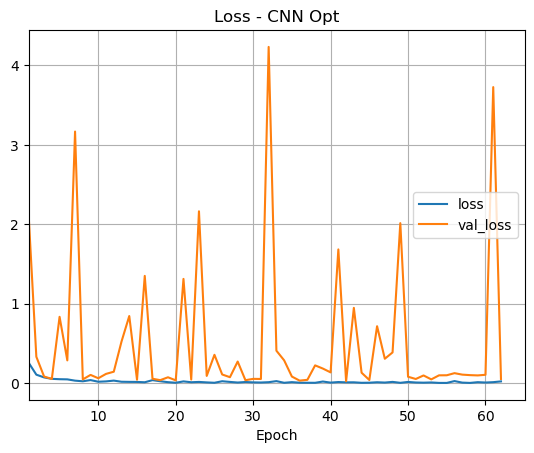

In [32]:
history_df_cnn = pd.DataFrame(history_cnn_opt.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN Opt")
plt.legend(cols, loc="right")
plt.show()

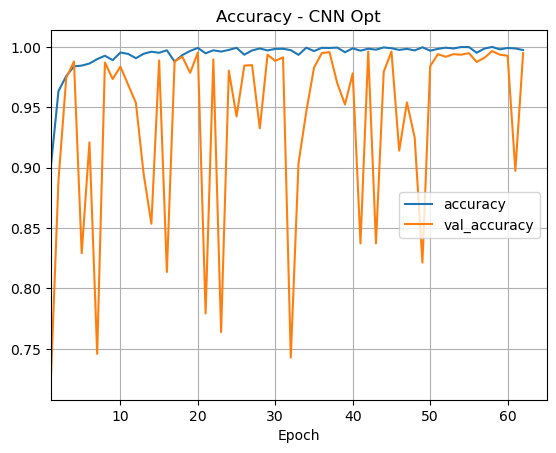

In [33]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN Opt")
plt.legend(cols, loc="right")
plt.show()

In [27]:
# Predict test set labels
y_pred_cnn_proba = best_cnn.predict(X_test, verbose=0)
y_pred_cnn = np.where(y_pred_cnn_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred_cnn):.5f}')

Accuracy: 0.99382


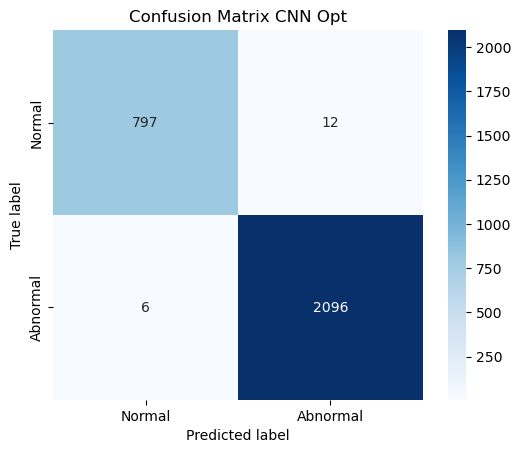

In [31]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure()
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix CNN Opt')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [29]:
print(classification_report(y_test, y_pred_cnn, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9925    0.9852    0.9888       809
    Abnormal     0.9943    0.9971    0.9957      2102

    accuracy                         0.9938      2911
   macro avg     0.9934    0.9912    0.9923      2911
weighted avg     0.9938    0.9938    0.9938      2911

